#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.29294608,  0.24248742,  0.92486888],
       [-0.20779395,  0.96033202, -0.18596799],
       [-0.93327609, -0.13770357,  0.33171292]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001634


In [33]:
Ret.shape

(50, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000232


In [37]:
C1(dx,dy,dz,Ret)

array([[ 6.34272445e+00, -1.07494138e-01, -1.46087558e+00,
        -7.43021653e-01,  3.17740663e-02,  2.86610425e+00,
         5.60011340e-01, -1.03358283e+00,  1.12471680e+00,
         7.25476655e-01,  1.91066000e+00,  8.36447052e-02,
         1.32147628e+00,  2.77752719e+00,  5.64117312e+00,
        -5.61574469e-01, -2.12964491e+00, -7.86827868e-01,
         6.78213204e-02, -5.56146572e-02, -1.18606781e-01,
         3.46679935e-01, -3.76526992e-01,  1.01970472e-04,
        -9.59679545e-01,  9.07555790e-03, -1.34369998e+00,
         1.05075428e-01,  8.67796058e-02, -8.89890501e-02,
        -3.10897520e+00,  7.58622836e+00,  2.73550632e+00,
        -4.56669770e-02,  2.22547454e+00, -3.38741323e-01,
        -1.90617675e+00,  3.97356685e-02, -1.87953638e-01,
        -1.37332143e+00, -1.18818047e-01,  3.07811897e-03,
        -3.53967823e-02,  2.04935796e-01, -5.14091827e-01,
         3.49534341e-02, -3.67222336e-01,  2.58456294e+00,
         1.17695056e-02,  7.18220305e-01],
       [ 1.27

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 3.64011109e+04,  7.34456344e+01, -1.36296947e+02],
       [-6.16912504e+02,  2.76145709e+02, -1.60335209e+04],
       [-8.38401455e+03,  1.15180406e+01,  5.06480072e+01],
       [-4.26422648e+03, -1.44327718e+03, -1.93917935e+02],
       [ 1.82352445e+02, -1.43365003e+03, -1.09753525e+04],
       [ 1.64486696e+04, -6.86681992e+03, -4.22096953e+03],
       [ 3.21392409e+03, -9.36023734e+03,  3.43047415e+03],
       [-5.93176691e+03, -4.89708236e+03, -2.56942718e+04],
       [ 6.45478786e+03, -3.73322676e+03,  1.41041813e+04],
       [ 4.16353514e+03,  1.38719648e+03,  1.07308431e+04],
       [ 1.09653426e+04,  7.43430858e+03, -7.22535557e+03],
       [ 4.80039802e+02, -1.81880127e+03, -4.29361341e+02],
       [ 7.58399719e+03,  9.93044243e+03, -1.37954596e+02],
       [ 1.59403228e+04,  5.02676746e+03,  2.10953783e+03],
       [ 3.23748840e+04,  4.35781350e+02,  4.07599055e+03],
       [-3.22289494e+03, -2.87868834e+03,  2.65880882e+03],
       [-1.22221044e+04,  2.55535877e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000288


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000329


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR) 

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000024


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[-0.09469528, -1.33357794,  0.52907292],
       [ 0.9365675 ,  0.7252323 ,  0.5436897 ],
       [ 0.08511939,  1.27841556,  0.6605925 ],
       [-0.06457428,  0.07462183, -0.92830716],
       [-0.04964963,  1.72769373, -0.59286618],
       [ 0.54540163, -1.093262  ,  0.10185797],
       [-2.24703178, -0.71994067,  0.44076939],
       [-0.72816066, -0.52699185,  0.25122845],
       [-1.02600677, -0.84927671,  1.57762004],
       [ 0.83264329,  0.45727574,  0.68977634],
       [ 0.32269152,  0.77699235, -0.42680012],
       [ 0.56707552,  1.54785126,  0.44691732],
       [ 0.08833093,  2.96481088,  0.25709256],
       [ 0.79248775,  0.03186147, -0.30773824],
       [-0.75963667,  0.36487805, -1.03864298],
       [-0.18758305,  0.1917773 ,  1.03737024],
       [-1.11345821, -0.12348398,  1.44619093],
       [ 0.67450671, -0.5629744 , -0.01734299],
       [-0.62815314, -0.40143198, -1.96198382],
       [ 0.04161256, -0.5161049 , -0.58275182],
       [-0.37822816, -0.6204563 , -0.470

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000385


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000535


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000609


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[-0.05314756,  1.86196268, -1.16114709],
       [-0.13393147,  1.26605636, -0.24676004],
       [-0.44525248, -0.64531582,  0.71978251],
       [-0.38681527, -1.75174431,  1.63288851],
       [-0.06691219,  1.56723806, -0.54275948],
       [-1.80154375,  1.63154121, -0.0314832 ],
       [-0.20838725,  1.2934202 ,  0.77706779],
       [-0.3359144 , -0.91815344,  0.23598935],
       [-0.81942751, -0.7208971 , -0.57653333],
       [-0.07532811,  1.50813465,  0.37477279],
       [-1.51089379,  1.40554616,  0.07281386],
       [-0.60115426,  0.64148485,  0.56722214],
       [-0.95886295, -1.31829341,  0.90375951],
       [-1.8136543 ,  0.44774288, -0.36286329],
       [ 0.90969173,  0.47426065, -0.43152652],
       [-0.34450377, -1.11506588, -0.97067834],
       [-0.01637417, -0.70130152,  0.48959226],
       [ 0.30120579, -0.08591675,  0.37707387],
       [-1.09254391,  1.47922682,  1.03997403],
       [ 0.06910949,  0.55812717,  0.59883527],
       [ 0.06956285,  0.60936359, -0.151

In [63]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[ 1.66974745e-02, -1.59639759e-03, -5.49482483e-03,
        -9.02414347e-03, -2.07988834e-02,  1.07011061e-02,
         1.04108116e-02,  6.97782020e-03,  2.18018620e-02,
         2.11671900e-03, -1.07956523e-02, -9.82958865e-03,
        -2.42194940e-02, -3.05530295e-03, -1.26150153e-02,
         7.62173762e-03,  1.41232548e-02,  4.88225780e-03,
        -1.40684828e-02, -6.26825028e-04,  1.32131930e-03,
        -4.92590794e-03, -6.05325840e-03,  2.61634808e-02,
        -9.43993930e-03, -1.15931501e-02,  1.43961240e-02,
        -8.13489620e-04, -2.53617790e-02, -3.40112080e-03,
         8.74667397e-03, -5.32986932e-03,  2.09099438e-02,
        -2.25711274e-02,  3.79829881e-03, -7.24158803e-03,
         4.20707536e-03, -4.47202530e-03, -4.47137675e-03,
         3.21799198e-02, -2.12756551e-02, -6.59885375e-03,
         1.20290686e-05, -5.17863271e-03,  7.01489660e-03,
         1.15039100e-04,  3.83881588e-04,  1.65979387e-02,
         1.97800449e-02,  8.29201306e-04],
       [-5.38

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000956


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-3.33876186e-08, -1.82421180e-06, -4.10251973e-08,
        -8.25202802e-07, -2.15602712e-06, -8.92872824e-07,
         2.99887003e-06,  3.93486170e-07, -2.88478761e-07,
        -1.92816109e-06,  1.01369706e-07, -7.98032078e-07,
         3.10549852e-06,  8.56028536e-07, -4.82316197e-07,
        -5.56078858e-07, -7.38814876e-07,  2.74703810e-07,
         2.13346742e-06,  2.35297072e-09,  1.70161689e-07,
         1.47010853e-06,  9.39815330e-07,  4.55165971e-06,
         1.52136462e-07,  2.31044398e-06,  3.99242237e-06,
         1.04971263e-06, -1.07968591e-06,  3.69923107e-06,
        -1.23424205e-07,  2.31977968e-07,  3.09536177e-06,
        -1.34197229e-06, -6.17201809e-08,  2.18784752e-06,
         6.50016660e-07, -2.59294636e-07, -1.71618394e-06,
        -8.18618436e-07, -5.68738720e-07, -6.55490375e-07,
         2.93378346e-06, -4.16505224e-08,  4.43403700e-07,
        -2.96164161e-08, -1.78167900e-06,  1.05600680e-07,
        -1.25873192e-07, -6.79182587e-07],
       [ 5.53

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-3.64011109e+04,  6.16912504e+02,  8.38401455e+03,
         4.26422648e+03, -1.82352445e+02, -1.64486696e+04,
        -3.21392409e+03,  5.93176691e+03, -6.45478786e+03,
        -4.16353514e+03, -1.09653426e+04, -4.80039802e+02,
        -7.58399719e+03, -1.59403228e+04, -3.23748840e+04,
         3.22289494e+03,  1.22221044e+04,  4.51563184e+03,
        -3.89228859e+02,  3.19174405e+02,  6.80688343e+02,
        -1.98960791e+03,  2.16090118e+03, -5.85212001e-01,
         5.50763348e+03, -5.20849348e+01,  7.71153981e+03,
        -6.03031446e+02, -4.98031103e+02,  5.10711179e+02,
         1.78425142e+04, -4.35376220e+04, -1.56991636e+04,
         2.62084331e+02, -1.27720739e+04,  1.94404795e+03,
         1.09396130e+04, -2.28044350e+02,  1.07867231e+03,
         7.88153828e+03,  6.81900804e+02, -1.76654292e+01,
         2.03143335e+02, -1.17613349e+03,  2.95039044e+03,
        -2.00598945e+02,  2.10750145e+03, -1.48328944e+04,
        -6.75455923e+01, -4.12189071e+03],
       [-7.34

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.001237


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-2.12105594e+01, -1.88279785e+04,  2.33087829e+05],
       [-8.22919670e+01, -1.03491983e+06,  1.86624625e+06],
       [ 6.56322431e+01,  2.64619192e+06, -3.30931145e+06],
       [-6.23190473e-01,  5.83655675e+03,  4.58318683e+02],
       [-7.42028160e+01, -3.05951777e+04,  7.80157979e+05],
       [ 3.84902664e+01, -3.89103779e+05,  3.13290882e+02],
       [ 9.06004173e+01, -5.48156127e+05, -3.67018048e+05],
       [ 7.03049954e+01,  2.66391460e+06, -3.37423693e+06],
       [-2.30653525e+02,  1.77899955e+06,  5.50861553e+05],
       [-4.46335484e+01, -1.28462406e+04,  4.63713586e+05],
       [ 3.60735952e+00, -3.63942082e+04, -4.37628322e+01],
       [ 4.28203338e+02, -2.86830448e+06, -1.45705487e+06],
       [-3.15193409e+01,  8.09271370e+05, -4.90919119e+05],
       [-1.63066713e+02,  6.30197040e+05,  1.01699273e+06],
       [ 9.37734485e+01, -1.12997696e+06,  1.82779836e+05],
       [ 3.98825475e+01,  6.48975311e+04, -4.67775182e+05],
       [-6.14159286e+01,  3.84202749e+06

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[ 2.35610715e+07,  2.33111154e+07,  1.88513028e+06],
       [-2.51398881e+07,  1.86622136e+08,  1.03489494e+08],
       [-1.44881878e+08, -3.30945488e+08, -2.64633534e+08],
       [ 5.82800996e+06,  4.64088413e+04, -5.83078731e+05],
       [-3.70370349e+01,  7.80157979e+07,  3.05951777e+06],
       [ 7.03545467e+05,  3.13987392e+04,  3.89104476e+07],
       [-2.03446798e+07, -3.67038189e+07,  5.48135986e+07],
       [-1.72942079e+08, -3.37440815e+08, -2.66408580e+08],
       [-3.86329181e+08,  5.50479087e+07, -1.77938200e+08],
       [-2.44544833e+05,  4.63713344e+07,  1.28459985e+06],
       [-4.24520685e+06, -4.79655877e+03,  3.63900057e+06],
       [-4.14106286e+08, -1.45746483e+08,  2.86789453e+08],
       [ 3.23522131e+05, -4.90918799e+07, -8.09271050e+07],
       [-5.00780678e+06,  1.01698777e+08, -6.30201997e+07],
       [-7.00961101e+08,  1.82085884e+07,  1.12928305e+08],
       [-8.28175512e+07, -4.67857171e+07, -6.49795164e+06],
       [-3.35986317e+08, -3.22216057e+08

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000338


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):
    
    def f(a,b,c,Ret,omega, dummy2): 
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()
   
    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001343


In [82]:
d_me_

array([[-1.32912865e-02,  7.93498725e+01,  5.49083063e+01],
       [-7.96001189e-02, -2.39726830e+01,  8.28056112e+02],
       [ 2.29754775e-02, -3.93217966e+02,  1.61150640e+02],
       [-1.06270301e-03,  3.14726142e+01, -2.07392931e+01],
       [-7.10248398e-02, -2.98147719e+00,  7.20440487e+02],
       [ 3.93968662e-03, -3.21180130e+01, -7.67718364e+00],
       [-4.12943305e-02,  1.67835368e+01,  4.00351129e+02],
       [-4.68039529e-02, -5.22023413e+01,  5.24996066e+02],
       [ 6.31267756e-04,  2.56667313e+02, -2.63057084e+02],
       [-8.42086550e-02,  2.60054737e+00,  8.48034757e+02],
       [ 3.50781211e-04,  2.23256558e+01, -2.58702107e+01],
       [ 6.32899142e-03,  6.77033064e+01, -1.31639172e+02],
       [ 2.19515599e-02, -2.68414549e+02,  4.66840242e+01],
       [ 1.54859656e-03, -1.02793699e+02,  8.71557289e+01],
       [-3.77297183e-03,  5.37999377e+02, -4.99913889e+02],
       [-2.35426250e-02,  1.80780159e+02,  5.70269835e+01],
       [-1.25197414e-02, -1.59252818e+02

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-3.64011109e+04,  6.16912504e+02,  8.38401455e+03,
         4.26422648e+03, -1.82352445e+02, -1.64486696e+04,
        -3.21392409e+03,  5.93176691e+03, -6.45478786e+03,
        -4.16353514e+03, -1.09653426e+04, -4.80039802e+02,
        -7.58399719e+03, -1.59403228e+04, -3.23748840e+04,
         3.22289494e+03,  1.22221044e+04,  4.51563184e+03,
        -3.89228859e+02,  3.19174405e+02,  6.80688343e+02,
        -1.98960791e+03,  2.16090118e+03, -5.85212001e-01,
         5.50763348e+03, -5.20849348e+01,  7.71153981e+03,
        -6.03031446e+02, -4.98031103e+02,  5.10711179e+02,
         1.78425142e+04, -4.35376220e+04, -1.56991636e+04,
         2.62084331e+02, -1.27720739e+04,  1.94404795e+03,
         1.09396130e+04, -2.28044350e+02,  1.07867231e+03,
         7.88153828e+03,  6.81900804e+02, -1.76654292e+01,
         2.03143335e+02, -1.17613349e+03,  2.95039044e+03,
        -2.00598945e+02,  2.10750145e+03, -1.48328944e+04,
        -6.75455923e+01, -4.12189071e+03],
       [-7.34

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

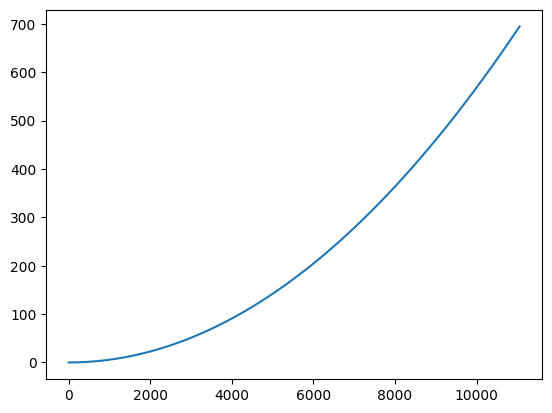

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    
    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 
    
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    
    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)
    
    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [101]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_44905/701681181.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(static_func, q0)


In [103]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
q0=root

In [106]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

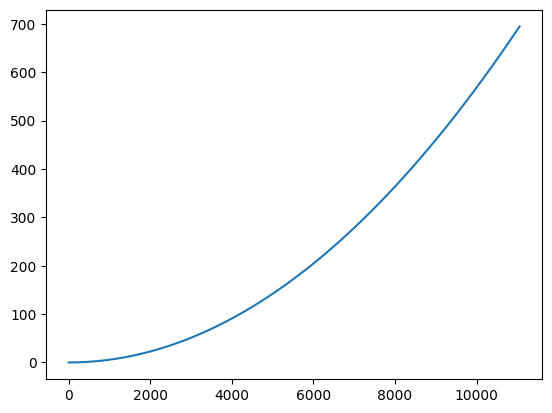

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L
    
    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3], 
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])  
    
    
    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])
        
        
    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1), 
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)           

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]    
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]
    
    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e6, G=84e6, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):
    coord=np.array(coord)
    elcon=np.array(elcon)
    
    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
    
    glob_force = np.dot(K,np.array(vessel_movement))
    
    
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    F=np.zeros(len(coord)*6) 
    
    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]
#     print(F,'F')
#     print(F)
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T.astype(np.float64)
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)), 
        bc_val=[0]*18,
        vessel_movement=[-0.1,0,0.20,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0],
        coefs=[-2.8871936495153606e-11,
                     -6.420113853324568e-13,
                     -2.6210770865292446e-13,
                     6.589949469337566e-11,
                     3.006123049327487e-11,
                     4.4185824290181994e-11])

In [113]:
d

array([-0.09993548, -0.0009415 ,  0.20035814,  0.02046151,  0.0246436 ,
        0.01610006,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [114]:
f

array([-1.41720833e+05, -2.08311146e-11,  2.82654167e+05,  6.36646291e-11,
       -1.53321800e-12, -1.20508048e-11,  1.39909676e+05, -4.33226986e+02,
       -1.52499893e+03, -2.86461128e+01, -2.46000357e+03,  4.24439657e+02,
        1.27774152e+03, -5.55347597e+02, -2.80501392e+05,  5.46560268e+02,
        1.74410710e+03, -2.25400823e+01,  5.33416001e+02,  9.88574584e+02,
       -6.27775780e+02, -1.36297448e+03, -2.58757760e+01, -1.23588262e+03])

In [115]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e9, G=84e9, A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2):
    coord=np.stack((X,Y,Z)).T 
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])
        
    bc_node=list(range(6))
    bc_val=[0]*6
    
    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement
    
    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)
#     print('d',d)
    
    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])
        
    mom =[]   
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])
        
    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3]) 
    return np.array(fors), np.array(mom), np.array(angle)

In [116]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,[0.1,
                0.2, 
                 0.3, 
                 0.01, 
                 -0.05, 
                 0.03],
                [-2.8871936495153606e-11,
                     -6.420113853324568e-13,
                     -2.6210770865292446e-13,
                     6.589949469337566e-11,
                     3.006123049327487e-11,
                     4.4185824290181994e-11])

In [117]:
fors

array([[ 2.91946193e-04, -2.25745040e-09,  3.28393494e-07],
       [ 1.84119386e-12,  2.86595758e-11,  1.27109503e-11],
       [ 2.69118061e-12, -1.20027493e-11,  1.05935538e-11],
       [ 5.33084688e-12,  4.38952281e-11, -3.17657012e-12],
       [ 6.80699941e-12,  8.27160741e-13, -1.76928472e-11],
       [ 8.29913915e-12, -9.57225143e-12,  1.34985356e-11],
       [ 6.93489710e-12, -2.01355431e-11,  5.28919131e-11],
       [ 8.95283847e-12,  6.83609019e-11,  1.18318688e-11],
       [ 5.91171556e-12, -5.87525623e-12, -6.85673740e-13],
       [-2.27373675e-13, -1.18168113e-11,  3.95772304e-11],
       [-3.18323146e-12, -2.95793720e-11,  2.25384156e-11],
       [-1.00044417e-11,  5.88941215e-12,  3.12709858e-11],
       [-1.06865627e-11, -7.97298534e-13,  1.07860387e-11],
       [-1.54614099e-11, -4.02050192e-12, -4.91695573e-12],
       [-1.36424205e-11, -4.24900902e-12, -1.98951966e-13],
       [-1.95541361e-11, -5.64966801e-12, -3.06243919e-11],
       [-2.45563569e-11,  1.56168573e-11

### Vessle Simulation

In [118]:
sampleTime = 0.001              # sample time [seconds]
N = 50000                      # number of samples

In [119]:
N*sampleTime

50.0

In [120]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0) 

In [121]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [122]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

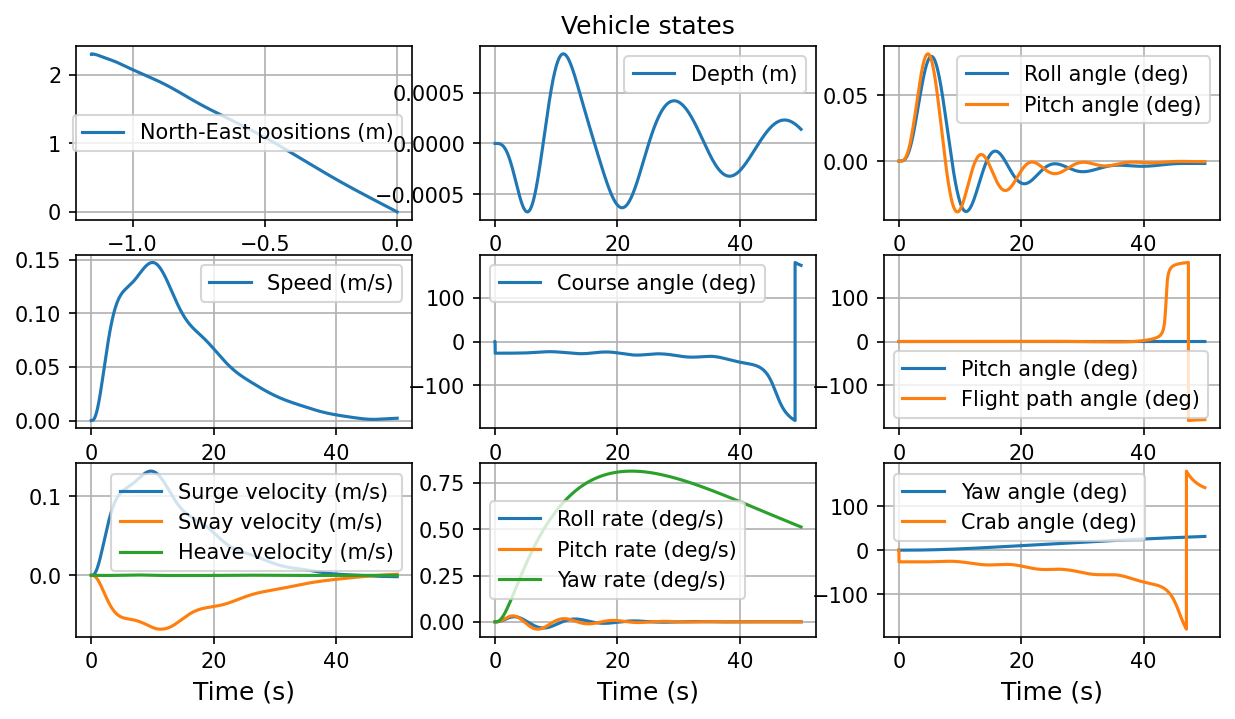

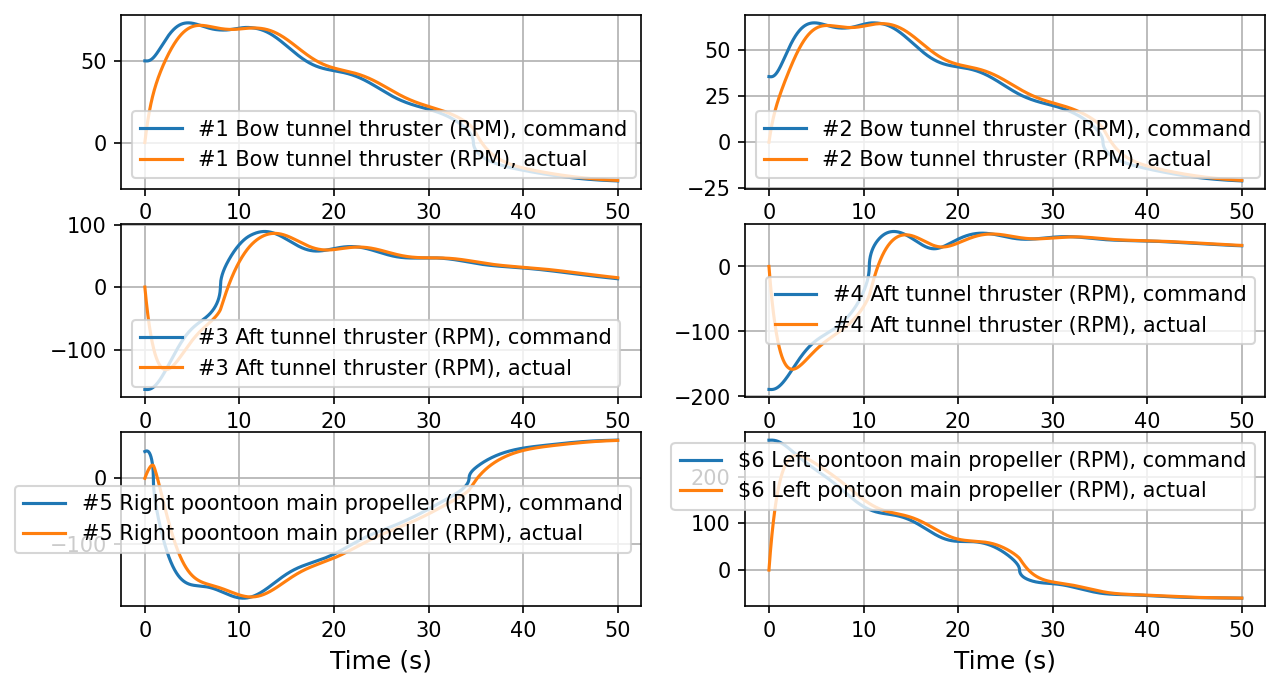

In [123]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [124]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

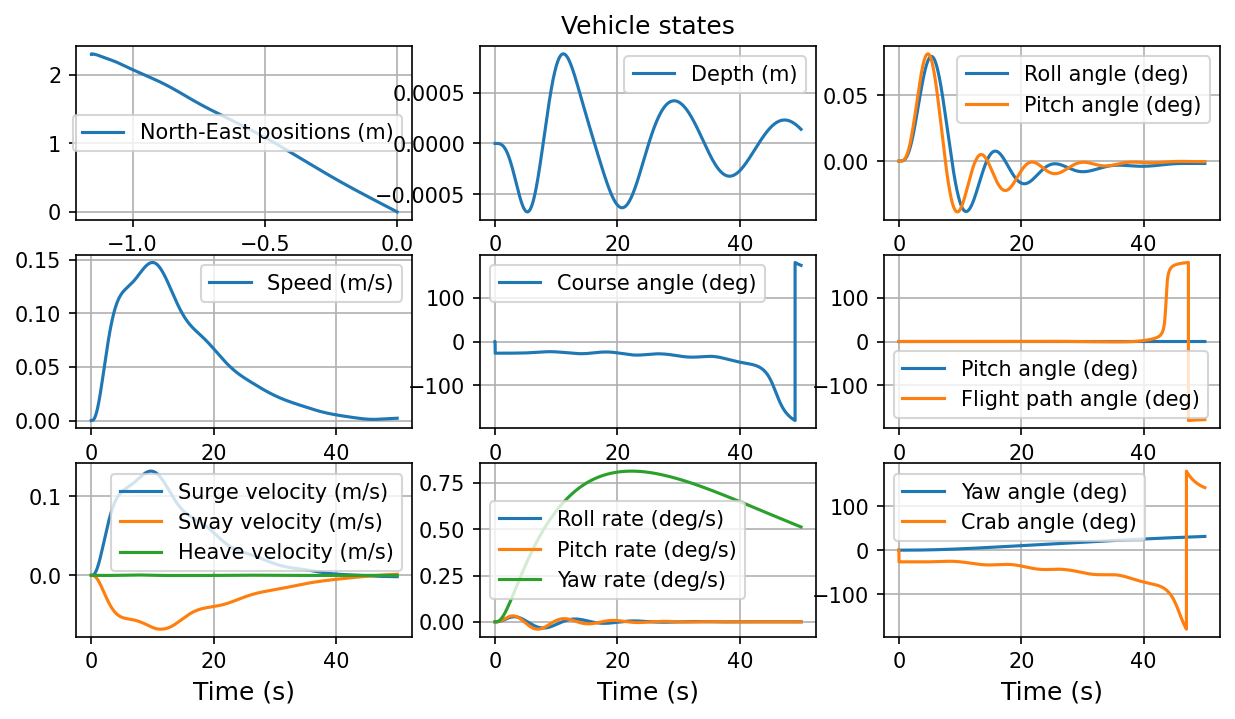

In [125]:
plotVehicleStates(simTime, simData, 3)

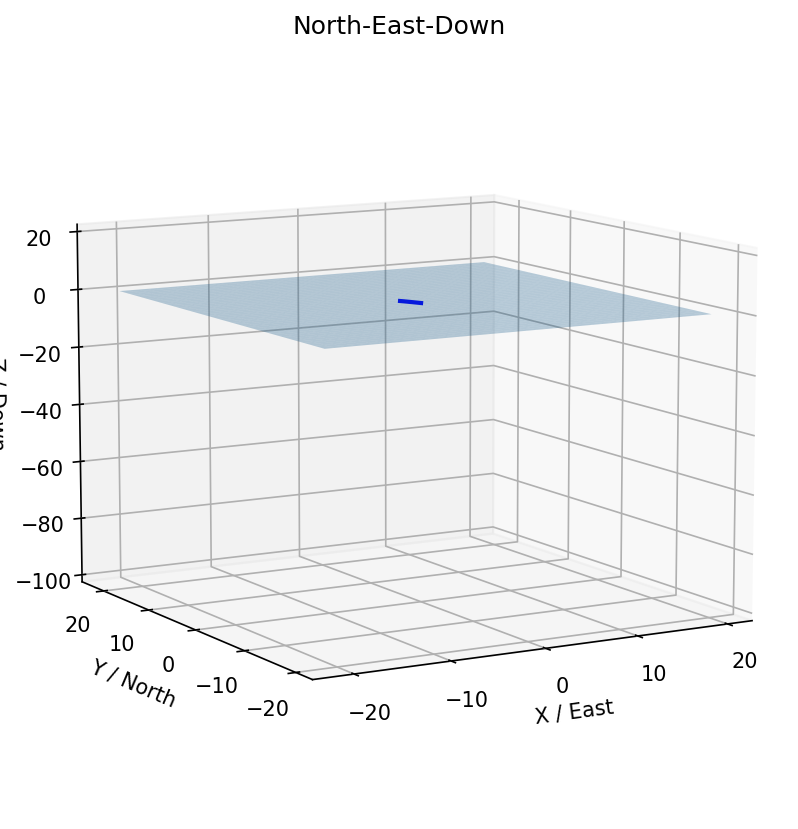

In [126]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [127]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [128]:
idx=1/0.01

In [129]:
idx

100.0

In [130]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [131]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [132]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [133]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [134]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [135]:
class MyTime:
    def __init__(self):
        self.my_t=0
        self.v_m=np.array([0,0,0,0,0,0]).astype(np.float64)

In [136]:
def grayscott1d(t, Q, coefs, T): 
#     print(t,T.my_t,t-T.my_t)
    print(t)
#     if (t-T.my_t)!=0 and abs(t-T.my_t)<1e-10:
#         return 'error'
     
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
   
    
    
#     u_ve = simData[:, 6][idx]
#     v_ve = simData[:, 7][idx]
#     w_ve = simData[:, 8][idx]
#     p_ve = simData[:, 9][idx]
#     q_ve = simData[:, 10][idx]
#     r_ve = simData[:, 11][idx]
    
    
#     η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_[2])
  
    
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    φ=ssa(φ)
    θ=ssa(θ)
    ψ=ssa(ψ)
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    
    vessel_movement = np.zeros(6).astype(np.float64)
    vessel_movement[0] =T.v_m[0]-x_ve
    vessel_movement[1] =T.v_m[1]-y_ve
    vessel_movement[2] =T.v_m[2]-z_ve
    vessel_movement[3] =T.v_m[3]-phi_ve
    vessel_movement[4] =T.v_m[4]-theta_ve
    vessel_movement[5] =T.v_m[5]-psi_v
    
 
    T.v_m[0]=x_ve
    T.v_m[1]=y_ve
    T.v_m[2]=z_ve
    T.v_m[3]=phi_ve
    T.v_m[4]=theta_ve
    T.v_m[5]=psi_v
    
    
#     print(vessel_movement )
#     print(T.v_m,"l")
    
    
#     print(vessel_movement)
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)
#     vessel_movement0=vessel_movement
#     print(fors.astype(np.float64))
    
    φ,θ,ψ=angle.T

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()
#     print(fors)

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T

  
    Z= (
        Z1
        + Z2 
        +Z0
       )

############################################################    
    RRRR=Re_b(Ret)

    
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################      
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
    
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)
 
    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t
#     T.v_m=np.copy(vessel_movement)
  
    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [137]:
tspan = (0., 50)
T_ = MyTime()

In [190]:
coefs = [2.723630019939446e-8, 
         9.976188723589116e-9,
         -1.804550202942943e-8, 
         4.7028305097320076e-8, 
         5.679495713505435e-8, 
         -4.361222240850402e-8]

In [191]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,  
             tspan, 
             q0,
#             method='LSODA',
#              t_eval=[i*sampleTime/10 for i in range(int(tspan[-1]/(sampleTime/10)))],
#              atol=1e-2,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

0.0
4.140986765291469e-09
8.281973530582939e-08
1.2422960295874405e-07
3.3127894122331755e-07
3.6808771247035276e-07
4.140986765291469e-07
4.140986765291469e-07
5.029283378002443e-07
5.47343168435793e-07
7.694173216135365e-07
8.088971710673575e-07
8.58246982884634e-07
8.58246982884634e-07
1.7465435955956081e-06
2.190691901951095e-06
4.411433433728531e-06
4.8062319282667404e-06
5.2997300464395044e-06
5.2997300464395044e-06
1.4182696173549246e-05
1.8624179237104115e-05
4.083159455487847e-05
4.4779579500260576e-05
4.971456068198821e-05
4.971456068198821e-05
0.00013854422195308562
0.0001829590525886343
0.00040503320576637785
0.00044451305522019886
0.0004938628670374752
0.0004938628670374752
0.0013821594797484493
0.0018263077861039364
0.004047049317881372
0.004441847812419582
0.004935345930592345
0.004935345930592345
0.013818312057702085
0.018259795121256955
0.04046721043903131
0.04441519538441341
0.049350176566141046
0.049350176566141046
0.1124429464129332
0.14398933133632927
0.30172125595

3.388193168036239
3.3926837673210044
3.3926837673210044
3.4005392686176457
3.4044670192659665
3.42410577250757
3.427597106417188
3.431961273804211
3.431961273804211
3.439896347312696
3.443863884066938
3.46370156783815
3.467228267175255
3.471636641346635
3.471636641346635
3.4794735826682537
3.4833920533290628
3.5029844066331086
3.506467491664939
3.5108213479547272
3.5108213479547272
3.5185875341273576
3.5224706272136723
3.541886092645248
3.545337730944195
3.549652278817878
3.549652278817878
3.557360650678959
3.5612148366094987
3.5804857662622
3.583911709311569
3.5881941381232805
3.5881941381232805
3.5961438727461963
3.6001187400576544
3.6199930766149446
3.623526292002907
3.6279428112378604
3.6279428112378604
3.635991608194054
3.640016006672151
3.660137999062635
3.6637152421542765
3.6681867960188286
3.6681867960188286
3.6763228292517995
3.6803908458682852
3.7007309289507133
3.7043469437209224
3.7088669621836843
3.7088669621836843
3.716814296188334
3.720787963190659
3.7406562982022833
3.7

6.7188472363852565
6.723273038962796
6.728805292184722
6.728805292184722
6.738605931403727
6.743506251013231
6.768007849060744
6.772363688713635
6.777808488279749
6.777808488279749
6.7875793014886625
6.792464708093119
6.816891741115401
6.821234324763807
6.826662554324314
6.826662554324314
6.836322717262749
6.841152798731966
6.8653032060780514
6.869596611828467
6.874963369016486
6.874963369016486
6.88482806085845
6.889760406779431
6.9144221363843394
6.918806443869657
6.924286828226303
6.924286828226303
6.934323263439782
6.939341481046522
6.964432569080221
6.9688932069528775
6.9744690042937
6.9744690042937
6.9845526240880496
6.989594433985224
7.014803483471098
7.019285092268587
7.024887103265448
7.024887103265448
7.034827457995898
7.039797635361123
7.064648522187246
7.069066457623002
7.074588876917696
7.074588876917696
7.084424096637562
7.089341706497495
7.11392975579716
7.118300964561545
7.123764975517026
7.123764975517026
7.133524446268702
7.13840418164454
7.16280285852373
7.1671404010

10.639168397171742
10.644594870617842
10.67172723784834
10.67655076980043
10.68258018474054
10.68258018474054
10.693470877747707
10.698916224251288
10.726142956769202
10.730983264772387
10.737033649776368
10.737033649776368
10.747965163184839
10.753430919889075
10.780759703410252
10.785618153814017
10.791691216818723
10.791691216818723
10.802572068308537
10.808012494053445
10.835214622777983
10.840050556773456
10.846095474267797
10.846095474267797
10.85702937973623
10.862496332470448
10.889831096141535
10.89469060968306
10.900765001609969
10.900765001609969
10.911667067293555
10.917118100135347
10.944373264344312
10.949218626870351
10.955275330027899
10.955275330027899
10.966245615303439
10.97173075794121
10.999156471130059
11.004032153474743
11.0101267564056
11.0101267564056
11.021170947249226
11.02669304267104
11.05430351978011
11.059212049043945
11.065347710623737
11.065347710623737
11.076461677472645
11.0820186608971
11.109803578019372
11.114743118841108
11.12091754486828
11.120917

14.981020679668983
14.987479547815095
15.019773888545652
15.025515104675529
15.032691624837875
15.032691624837875
15.04561240278593
15.052072791759956
15.084374736630089
15.090117304607002
15.097295514578143
15.097295514578143
15.110308872116125
15.116815550885114
15.149348944730068
15.155132659191395
15.16236230226805
15.16236230226805
15.175463201138438
15.182013650573632
15.214765897749599
15.220588519469771
15.227866796619987
15.227866796619987
15.240959841317737
15.247506363666611
15.280238975410986
15.286058106387765
15.293332020108737
15.293332020108737
15.306511421107958
15.313101121607566
15.346049624105616
15.351907135660825
15.359229025104836
15.359229025104836
15.372388865052923
15.378968785026967
15.411868384897184
15.41771720265189
15.42502822484527
15.42502822484527
15.438187068681422
15.444766490599498
15.477663600189878
15.483511975228168
15.49082244402603
15.49082244402603
15.503987751711533
15.510570405554283
15.543483674768039
15.549334922628262
15.556648982453542
1

19.885566257655608
19.891734123453478
19.899443955700814
19.899443955700814
19.913387524897107
19.920359309495254
19.955218232485983
19.961415374351002
19.969161801682276
19.969161801682276
19.983078322208012
19.990036582470882
20.02482788378523
20.031013004018888
20.038744404310965
20.038744404310965
20.05265303858087
20.059607355715826
20.094378941390598
20.100560556621666
20.108287575660505
20.108287575660505
20.122502121479197
20.129609394388545
20.16514575893528
20.1714633348547
20.179360304753974
20.179360304753974
20.193528714598447
20.200612919520683
20.236033944131865
20.242331015173853
20.250202353976338
20.250202353976338
20.264347840137148
20.271420583217555
20.306784298619583
20.31307118135772
20.320929784780393
20.320929784780393
20.33499180193806
20.342022810516895
20.37717785341106
20.383427638814467
20.391239870568725
20.391239870568725
20.405330799157216
20.412376263451463
20.44760358492269
20.45386621985091
20.46169451351118
20.46169451351118
20.475742704105404
20.48

25.50447430000392
25.5134864806442
25.5134864806442
25.529722563646846
25.53784060514817
25.57843081265478
25.585646849544844
25.594666895657426
25.594666895657426
25.611039143563193
25.619225267516075
25.66015588728049
25.667432441905277
25.676528135186256
25.676528135186256
25.692729542588555
25.70083024628971
25.74133376479546
25.748534390307594
25.75753517219776
25.75753517219776
25.77390066126104
25.782083405792683
25.822997128450886
25.83027067914568
25.83936261751417
25.83936261751417
25.85567049374941
25.86382443186703
25.904594122455137
25.91184206744858
25.92090199869038
25.92090199869038
25.937176293059995
25.945313440244806
25.98599917616885
25.993232195888677
26.002273470538466
26.002273470538466
26.018534130870602
26.02666446103667
26.06731611186701
26.074543072014627
26.083576772199148
26.083576772199148
26.100036243218746
26.108265978728546
26.14941465627754
26.156729976730695
26.165874127297137
26.165874127297137
26.182418399971077
26.190690536308043
26.23205121799289


32.16307437836687
32.18362071481319
32.193893883036345
32.245259724152135
32.254391429239384
32.26580606059845
32.26580606059845
32.286369460945856
32.296651161119556
32.348059661988074
32.357198951031364
32.36862306233548
32.36862306233548
32.38923718892771
32.39954425222382
32.451079568704394
32.46024140274538
32.47169369529662
32.47169369529662
32.49237770010892
32.50271970251507
32.55442971454582
32.56362260557351
32.575113719358114
32.575113719358114
32.59609615822425
32.60658737765732
32.65904347482267
32.668369003207616
32.6800259136888
32.6800259136888
32.7009787287417
32.71145513626815
32.7638371739004
32.773149536146136
32.7847899889533
32.7847899889533
32.805662725802975
32.816099094227816
32.868280936352015
32.8775577082852
32.88915367320169
32.88915367320169
32.91028309697717
32.9208478088649
32.973671368303584
32.98306222331491
32.99480079207906
32.99480079207906
33.01587988524165
33.02641943182295
33.07911716472944
33.08848565057948
33.10019625789203
33.10019625789203
33

42.22526085104372
42.2480358294901
42.2480358294901
42.29006089601273
42.311073429274046
42.416136095580626
42.43481390292402
42.45816116210326
42.45816116210326
42.501423244523366
42.523054285733416
42.63120949178368
42.650437083970395
42.674471574203785
42.674471574203785
42.71902162429307
42.741296649337706
42.85267177456091
42.872471796822815
42.897221824650195
42.897221824650195
42.943117495997605
42.96606533167131
43.08080451003984
43.10120258619424
43.12670018138725
43.12670018138725
43.17433797744768
43.19815687547789
43.31725136562897
43.33842371943361
43.3648891616894
43.3648891616894
43.414704724717474
43.43961250623152
43.56415141380172
43.586291664036416
43.61396697682979
43.61396697682979
43.66651152095739
43.69278379302119
43.8241451533402
43.847498284063576
43.876689697467796
43.876689697467796
43.93258956091873
43.960539492644195
44.10028915127153
44.1251335350275
44.156189014722464
44.156189014722464
44.21682718150642
44.24714626489839
44.39874168185827
44.42569197820

In [192]:
# key takeaway: it needed FEM model. Space frame element approximation is crude, but seems to work.
# The only parameter to tune is force_schedule

### Results

In [193]:
fin=us

In [194]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.141e-07 ...  4.999e+01  5.000e+01]
        y: [[ 0.000e+00  2.251e-20 ... -1.074e-06 -1.074e-06]
            [ 2.256e+02  2.256e+02 ...  2.256e+02  2.256e+02]
            ...
            [ 0.000e+00 -2.943e-10 ...  1.115e-05  1.105e-05]
            [ 0.000e+00 -3.012e-10 ...  1.139e-05  1.128e-05]]
      sol: None
 t_events: None
 y_events: None
     nfev: 3764
     njev: 0
      nlu: 0

In [195]:
t=fin.t

In [196]:
fin=fin.y.T

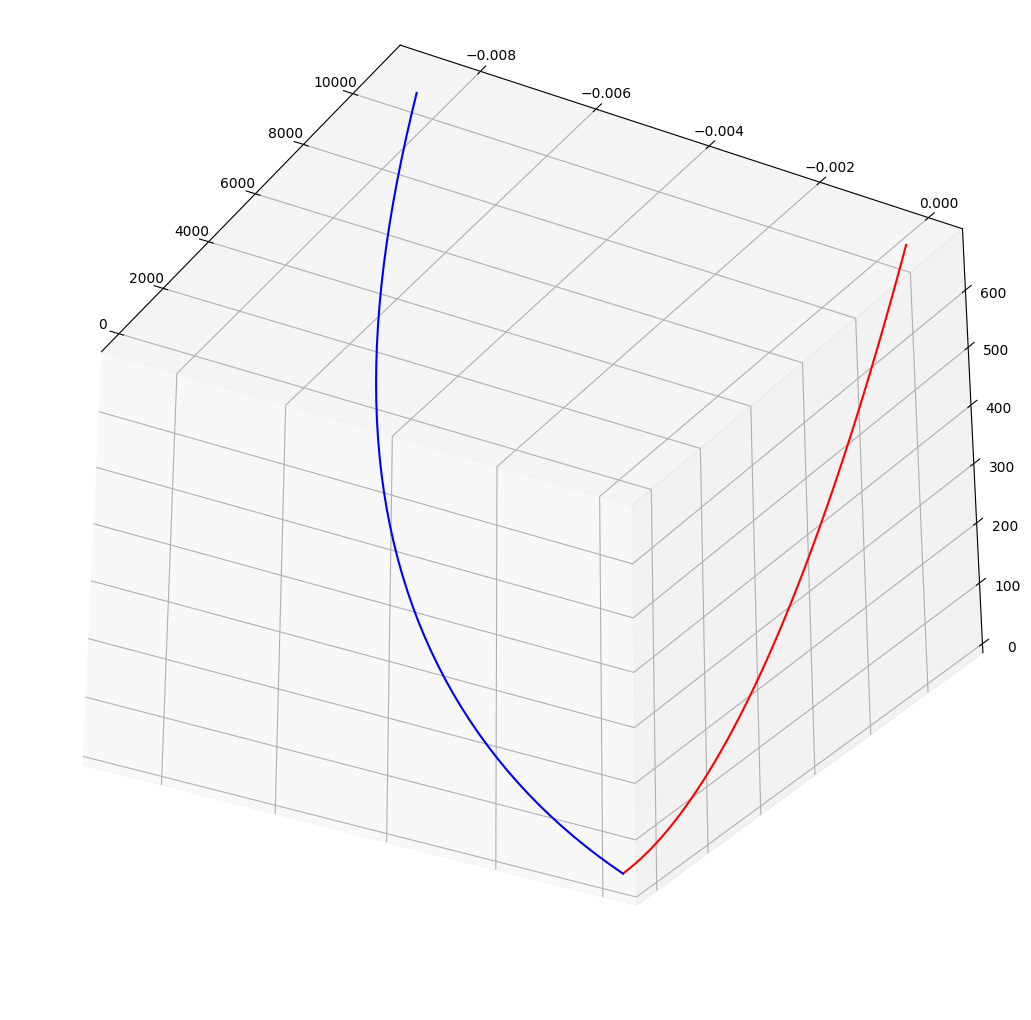

In [197]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [198]:
X,Y,Z

(array([-1.07424028e-06,  2.25564880e+02,  4.51129070e+02,  6.76691909e+02,
         9.02252773e+02,  1.12781107e+03,  1.35336625e+03,  1.57891779e+03,
         1.80446523e+03,  2.03000811e+03,  2.25554604e+03,  2.48107867e+03,
         2.70660568e+03,  2.93212680e+03,  3.15764179e+03,  3.38315047e+03,
         3.60865270e+03,  3.83414837e+03,  4.05963744e+03,  4.28511987e+03,
         4.51059572e+03,  4.73606505e+03,  4.96152798e+03,  5.18698467e+03,
         5.41243533e+03,  5.63788020e+03,  5.86331958e+03,  6.08875378e+03,
         6.31418318e+03,  6.53960817e+03,  6.76502921e+03,  6.99044677e+03,
         7.21586136e+03,  7.44127353e+03,  7.66668385e+03,  7.89209293e+03,
         8.11750139e+03,  8.34290989e+03,  8.56831911e+03,  8.79372975e+03,
         9.01914252e+03,  9.24455816e+03,  9.46997740e+03,  9.69540099e+03,
         9.92082970e+03,  1.01462643e+04,  1.03717055e+04,  1.05971541e+04,
         1.08226108e+04,  1.10480764e+04]),
 array([ 1.40322402e-10, -3.47672335e-04, -6

In [199]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [200]:
us=fin.T

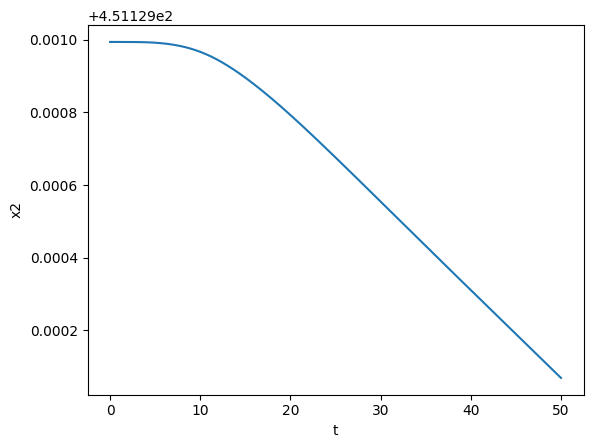

In [201]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

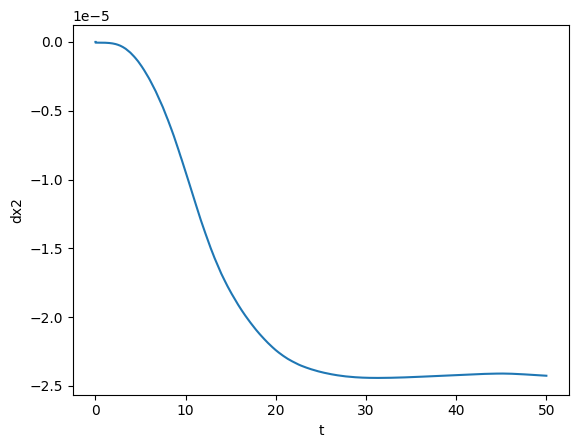

In [202]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

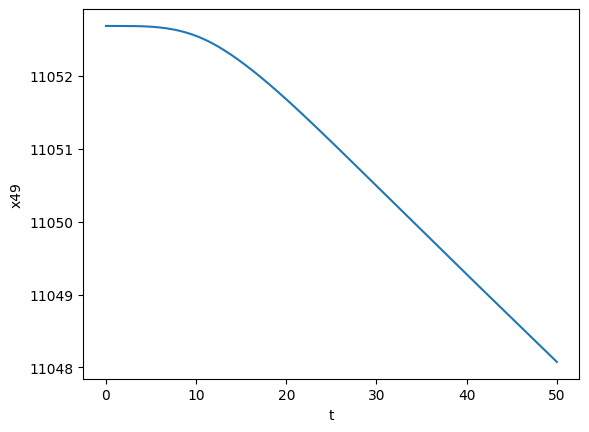

In [203]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

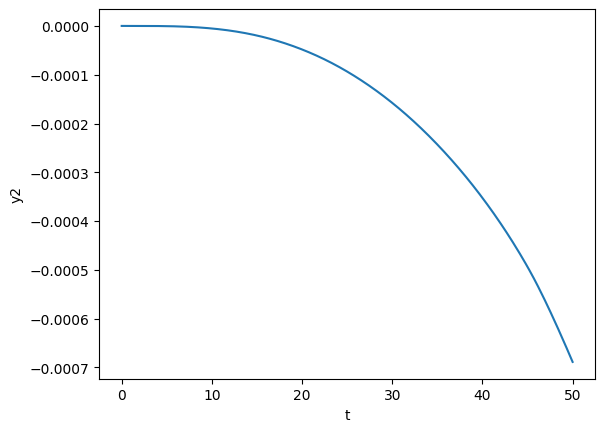

In [204]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

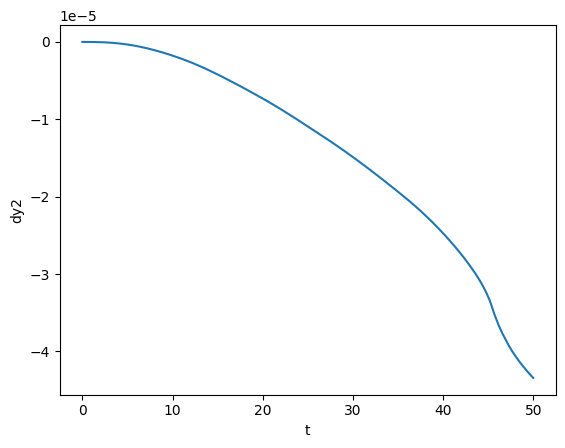

In [205]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

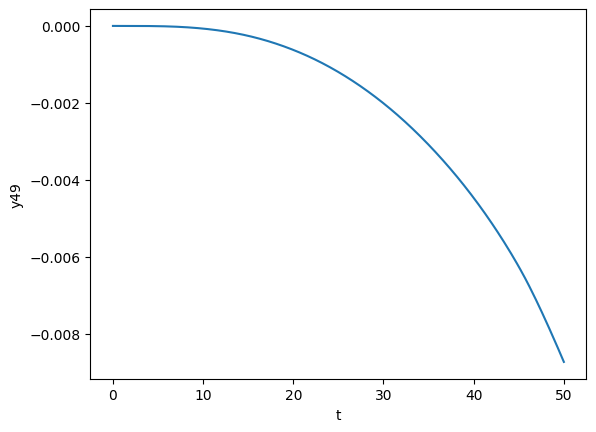

In [206]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

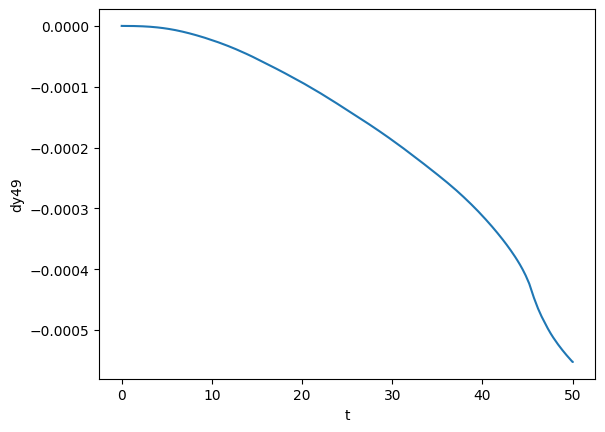

In [207]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

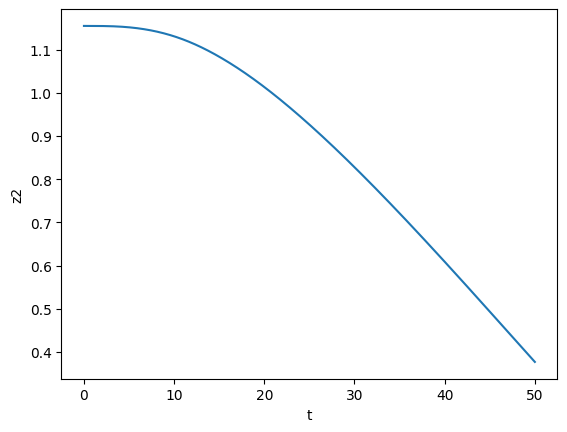

In [208]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

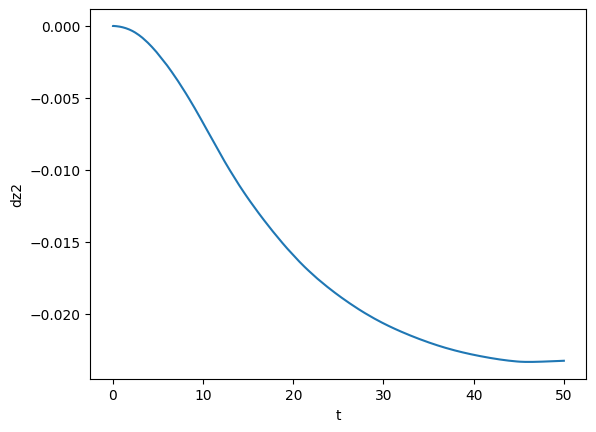

In [209]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

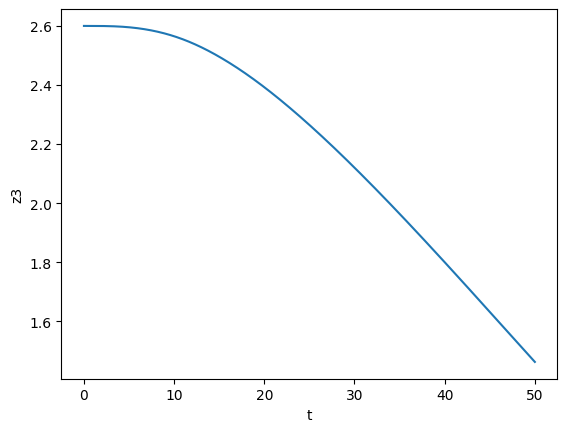

In [210]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

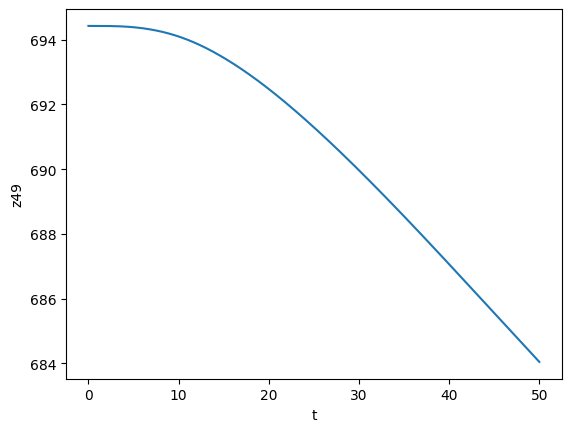

In [211]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

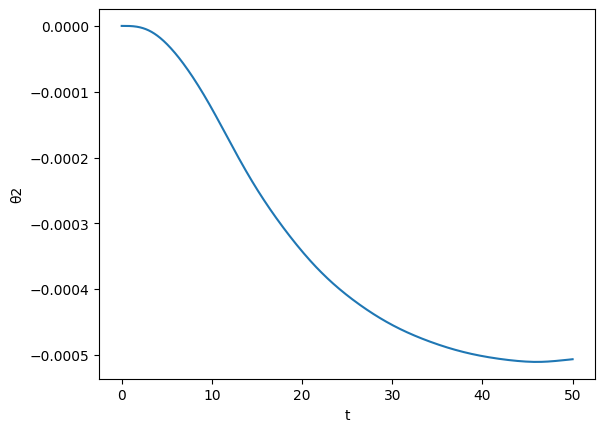

In [212]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

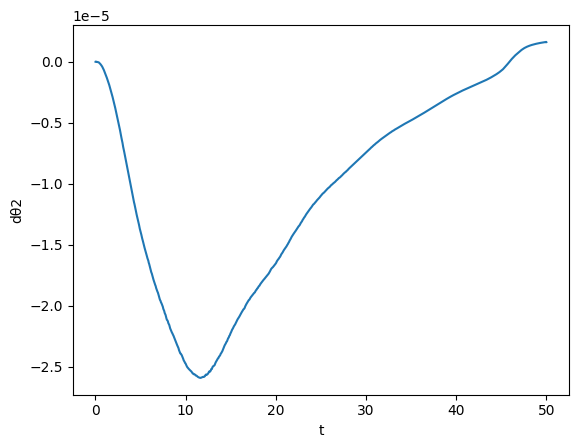

In [213]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

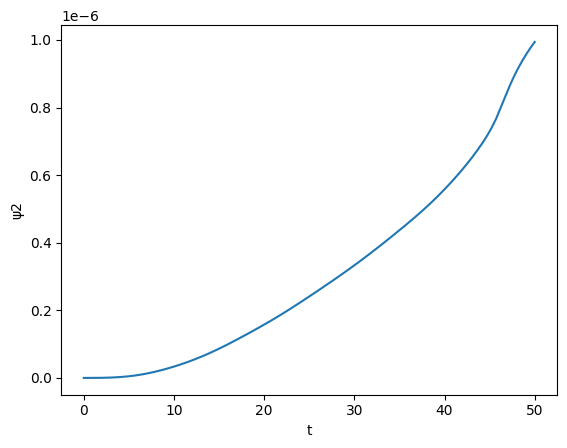

In [214]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

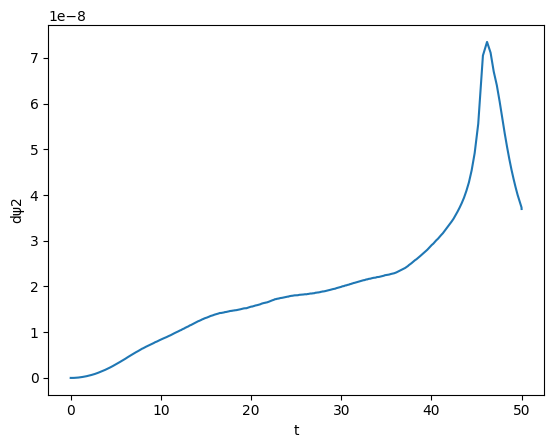

In [215]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()